In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ranksums
from matplotlib_venn import venn2, venn3
from PPTPseq_utils import *
sns.set_context("poster")
plt.rcParams['pdf.fonttype'] = 42

In [2]:
# read TFBS data
DAP_df = read_DAP_seq()
SELEX_df = read_gSELEX()
ChIPseq_df = read_ChIP_seq()
ChIPexo_df = read_ChIP_exo()
Binding_site_df = read_known_binding_sites()
# read TSS data
operon_to_TSS_map, operon_to_strand_map = read_TSS_map()
# read gene expression data
gene_to_expression_map = read_Ribo_seq()
gene_to_expression_map_ms = read_proteome_MS()
# read PPTP-seq data (M9 glucose condition)
PPTP_df = pd.read_csv('../Processed_data/PPTP-seq_Glu.csv')
PPTP_df.rename(columns={'sgRNA': 'tf_gene'}, inplace=True)
PPTP_df = update_tf_name(PPTP_df)

In [3]:
def identify_TFBS_in_PPTP_seq(TFBS_df, PPTP_df):
    df = TFBS_df[(TFBS_df['tf_gene'].isin(PPTP_df['tf_gene']))&(TFBS_df['operon'].isin(PPTP_df['operon']))]
    return df

In [4]:
# integrate TFBS datasets into PPTP-seq dataset
PPTP_with_binding_df = PPTP_df[PPTP_df['std']<CONSISTENCE_CUTOFF].set_index(['tf_gene','operon'])
TFBS_dfs = [Binding_site_df, DAP_df, SELEX_df, ChIPseq_df, ChIPexo_df]
for TFBS_df in TFBS_dfs:
    TFBS_df = identify_TFBS_in_PPTP_seq(TFBS_df, PPTP_df).set_index(['tf_gene','operon'])
    PPTP_with_binding_df = pd.concat([PPTP_with_binding_df, TFBS_df],join = 'outer', axis = 1)
PPTP_with_binding_df = PPTP_with_binding_df.reset_index()
PPTP_with_binding_df['Total_number_of_evidence'] = PPTP_with_binding_df[['known_TFBS', 'DAP_seq', 'gSELEX', 'ChIP_seq', 'ChIP_exo']].sum(1)

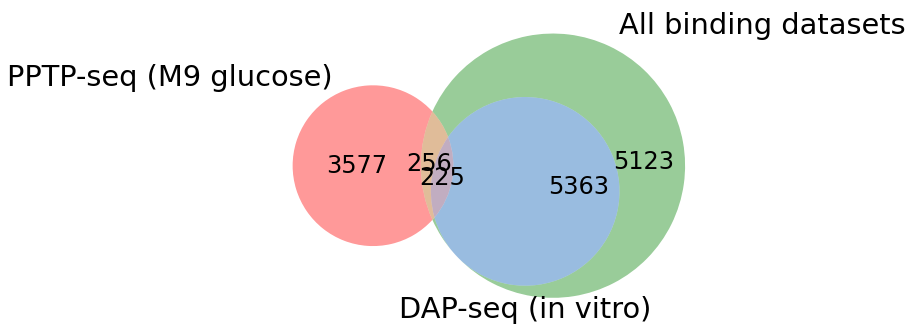

In [5]:
#Figure 5a
fig, ax = plt.subplots(1,1, figsize=(8,8))
df = PPTP_with_binding_df
label = ['PPTP-seq (M9 glucose)', 'All binding datasets', 'DAP-seq (in vitro)']
venn3([set(df[abs(df['class'])==1].index), 
       set(df[(df['Total_number_of_evidence']>0)&(df['class'].notna())].index),
       set(df[(df['FC_DAP']>0)&(df['class'].notna())].index)], label, ax = ax)

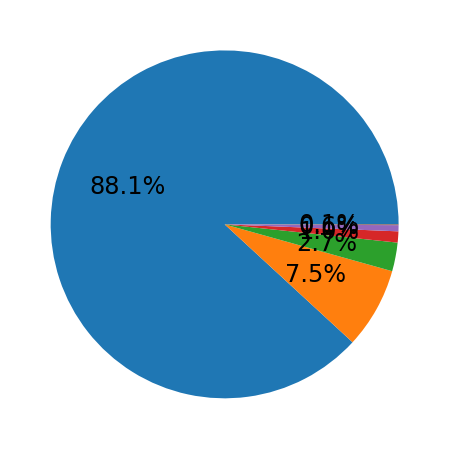

In [6]:
#Figure 5b
fig = plt.figure(figsize=(8, 8))
ax = plt.axes()
plt.pie(df[(abs(df['class'])==1)]['Total_number_of_evidence'].value_counts(), autopct='%.1f%%');

In [7]:
def get_responsive_promoter_per_TF(df):
    responsive_promoter_per_TF = pd.concat([
        df[(abs(df['class'])==1) & (df['Total_number_of_evidence']>0)]['tf_gene'].value_counts().rename('both'),
        df[(abs(df['class'])==1)]['tf_gene'].value_counts().rename('#responsive promoters')], axis = 1)
    responsive_promoter_per_TF['Fraction supported by binding'] = responsive_promoter_per_TF['both']/responsive_promoter_per_TF['#responsive promoters']
    return responsive_promoter_per_TF

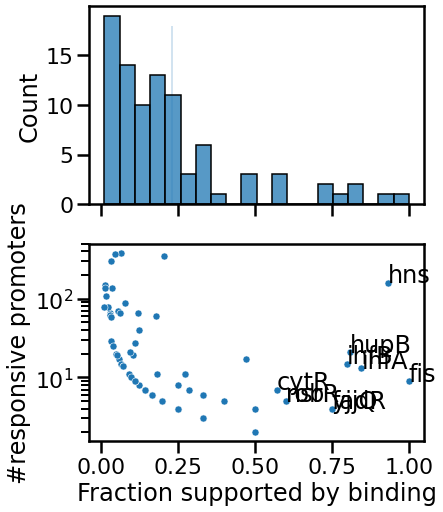

In [8]:
#Figure 5c
fig, axes = plt.subplots(2,1, figsize=(6,8),sharex=True)
df = get_responsive_promoter_per_TF(PPTP_with_binding_df)
# on average 23% of regulated promoters per TF were presumably direct targets 
AVERAGE = df['Fraction supported by binding'].mean()
sns.histplot(df['Fraction supported by binding'], bins = 20, ax = axes[0])
sns.lineplot(x = [AVERAGE, AVERAGE], y = [0, 18], ax = axes[0])
sns.scatterplot(data = df, x = 'Fraction supported by binding', y = '#responsive promoters', s=50, ax = axes[1])
plt.yscale('log')
for i, row in df.iterrows():
    if (row['Fraction supported by binding']>0.5):
        axes[1].annotate(row.name, (row['Fraction supported by binding'], row['#responsive promoters']), fontsize=24)
# fig.savefig('../Figures/binding/fraction_direct_regulating_glu.pdf', bbox_inches = 'tight', pad_inches = 0)

In [9]:
def get_factors_affecting_response(df = PPTP_with_binding_df):
    # only keep datasets with binding evidence and PPTP-seq response (not have to be significant)
    df_copy = df[(df['Total_number_of_evidence']>0)&(df['FC'].notna())].copy()
    df_copy['TSS'] = df_copy['operon'].map(operon_to_TSS_map)
    df_copy['operon_strand'] = df_copy['operon'].map(operon_to_strand_map)
    df_copy['rel_pos'] = calculate_relative_distance_to_TSS(df_copy)
    df_copy['tf_exp_ribo'] = df_copy['tf_gene'].map(gene_to_expression_map)
    df_copy['tf_exp_ms'] = df_copy['tf_gene'].map(gene_to_expression_map_ms['Glucose'])
    df_copy['FC_gSELEX_norm_TF'] = df_copy['Peak Intensity Fold Change/Binding intensity (%)']/100
    df_copy['FC_DAP_norm_TF'] = df_copy['FC_DAP']/df_copy.groupby('tf_gene')['FC_DAP'].transform('max')
    df_copy['FC_DAP_norm_promoter'] = df_copy['FC_DAP']/df_copy.groupby('operon')['FC_DAP'].transform('max')
    df_copy.loc[abs(df_copy['class'])==1,'regulating'] = 'Y'
    df_copy.loc[df_copy['class']==0,'regulating'] = 'N'
    df_copy['tf_exp_ribo_log10'] = np.log10(df_copy['tf_exp_ribo']+1)
    df_copy['tf_exp_ms_log10'] = np.log10(df_copy['tf_exp_ms']+1)
    return df_copy

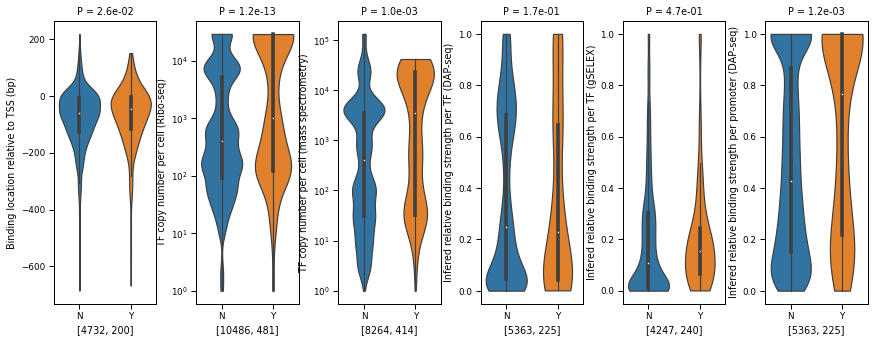

In [10]:
# Fig. 5d-i
sns.set_context("paper")
pvalues = []
num_variable = 6
fig, axes = plt.subplots(1,num_variable, figsize=(12,4.5))
from matplotlib import ticker as mticker
fig.tight_layout()
factors_df = get_factors_affecting_response(PPTP_with_binding_df)
col_list = ['rel_pos', 'tf_exp_ribo_log10', 'tf_exp_ms_log10', 'FC_DAP_norm_TF', 'FC_gSELEX_norm_TF', 'FC_DAP_norm_promoter']
ylabel_list = ['Binding location relative to TSS (bp)', 'TF copy number per cell (Ribo-seq)', 'TF copy number per cell (mass spectrometry)', 'Infered relative binding strength per TF (DAP-seq)', 'Infered relative binding strength per TF (gSELEX)','Infered relative binding strength per promoter (DAP-seq)']
for i in range(num_variable):
    df = factors_df[factors_df[col_list[i]].notna()]
    sns.violinplot(data = df,
               x = 'regulating',
               y = col_list[i],
               cut=0,
               ax = axes[i]
              )
    axes[i].set(xlabel = [(df['regulating']=='N').sum(),(df['regulating']=='Y').sum()], ylabel = ylabel_list[i])
    result = ranksums(factors_df[factors_df['regulating']=='Y'][col_list[i]], 
         factors_df[factors_df['regulating']=='N'][col_list[i]])
    pvalues.append(result.pvalue)
axes[1].yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
axes[2].yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))
# print p values in title
p_adj_values = p_adjust_bh(pvalues)
for i in range(num_variable):
    axes[i].set(title = 'P = '+"{:.1e}".format(p_adj_values[i]))